<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dataset-handling" data-toc-modified-id="Dataset-handling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dataset handling</a></span></li><li><span><a href="#Simple-psychometric-fits" data-toc-modified-id="Simple-psychometric-fits-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simple psychometric fits</a></span></li><li><span><a href="#Simplest-effects-of-CP-on-percent-correct" data-toc-modified-id="Simplest-effects-of-CP-on-percent-correct-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Simplest effects of CP on percent correct</a></span></li><li><span><a href="#Logistic-regression" data-toc-modified-id="Logistic-regression-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Logistic regression</a></span><ul class="toc-item"><li><span><a href="#Single-predictor" data-toc-modified-id="Single-predictor-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Single predictor</a></span><ul class="toc-item"><li><span><a href="#Signed-coherence" data-toc-modified-id="Signed-coherence-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Signed coherence</a></span></li></ul></li><li><span><a href="#Two-predictors" data-toc-modified-id="Two-predictors-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Two predictors</a></span></li></ul></li><li><span><a href="#With-glm-function" data-toc-modified-id="With-glm-function-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>With <code>glm</code> function</a></span></li></ul></div>

<!--
IRdisplay::display_html(file='../code_hiding.html')
if the line above generates an error, it could be due to this:
https://github.com/IRkernel/IRdisplay/issues/41
In the meantime, the code below is enough; it works on nbviewer but not on the notebook directly
-->

<script>
  code_show=true;
  function code_toggle() {
    if (code_show){
      $('div.input').hide();
    } else {
      $('div.input').show();
    }
    code_show = !code_show
  } 
  $( document ).ready(code_toggle);
</script>
<font size=4>
<a href="javascript:code_toggle()">Toggle ON/OFF</a>
code cells.
</font>

# Fitting psychometric functions

This notebook analyzes data from `Pilot 13-14` datasets.

In [1]:
library(data.table)
library(ggplot2)        
source('../../R/R_functions.r')

In [2]:
# define constants for notebook

# todo: the following is VERY INELEGANT!
psubj13 <- c(37,2.5,0.5,0.001)
names(psubj13) <- c('threshold','slope','guess','lapse')
psubj14 <- c(23,2.5,0.5,0.001)
names(psubj14) <- c('threshold','slope','guess','lapse')
QuestParams <- list(psubj13, psubj14)
names(QuestParams) <- c('13', '14')

# recall, to access threshold of subject 13, type
# th13 <- QuestParams[['13']]['threshold']

## Dataset handling

Let's load and inspect the dataset.

In [3]:
# load dataset
data <- fread('../../data/Pilot13-14/psychophysical_data.csv')
data[,presenceCP:=as.factor(presenceCP)]
data[,choice:=as.factor(choice)]

In [4]:
data[,signedCohLast := coherence]
data[signedCoherence < 0, signedCohLast := signedCoherence]
data[choice=="left" & presenceCP=="yes" & correct, signedCohLast:= - coherence]
data[choice=="right" & presenceCP=="yes" & !correct, signedCohLast:= - coherence]

In [5]:
str(data)

Classes ‘data.table’ and 'data.frame':	977 obs. of  12 variables:
 $ pilotID        : int  13 13 13 13 13 13 13 13 13 13 ...
 $ taskID         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ validTrialCount: int  1 2 3 4 5 6 7 8 9 10 ...
 $ choice         : Factor w/ 2 levels "left","right": 2 1 1 2 2 1 2 1 2 2 ...
 $ correct        : logi  TRUE FALSE TRUE TRUE TRUE TRUE ...
 $ presenceCP     : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ viewingDuration: num  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 ...
 $ signedCoherence: num  50 50 -57 57 56 -56 56 -55 55 55 ...
 $ coherence      : num  50 50 57 57 56 56 56 55 55 55 ...
 $ choice_time    : num  0.363 0.833 0.578 0.572 0.633 ...
 $ exactVD        : num  0.22 0.203 0.203 0.219 0.219 ...
 $ signedCohLast  : num  50 50 -57 57 56 -56 56 -55 55 55 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [6]:
print('first 6 rows of data.table')
head(data)

[1] "first 6 rows of data.table"


pilotID,taskID,validTrialCount,choice,correct,presenceCP,viewingDuration,signedCoherence,coherence,choice_time,exactVD,signedCohLast
13,1,1,right,TRUE,no,0.2,50,50,0.3633654,0.2203390,50
13,1,2,left,FALSE,no,0.2,50,50,0.8330632,0.2033898,50
13,1,3,left,TRUE,no,0.2,-57,57,0.5782815,0.2033898,-57
13,1,4,right,TRUE,no,0.2,57,57,0.5724611,0.2193786,57
13,1,5,right,TRUE,no,0.2,56,56,0.6325272,0.2188400,56
13,1,6,left,TRUE,no,0.2,-56,56,0.6130831,0.2033898,-56


## Simple psychometric fits 

Is the percent correct as a function of coherence value in the task node similar to the one estimated in the Quest node?

In [7]:
# steps
# 1. For each subject, get parameters of psychometric curve estimated by Quest
# 2. plot the curve
# 3. overlay data from task node, for appropriate viewing duration
# 4. overlay theoretical curve corresponding to the fitted logistic regression
# 5. plot everything

# The final plot should use a single data.table

# progress
# 1. complete
# 2. complete
# 3. complete

In [8]:
subj <- '13'
x <- seq(100)
psychometric <- psi_corr(weibull, QuestParams[[subj]])
y <- psychometric(x)

questCurve <- data.table(x=x, y=y)

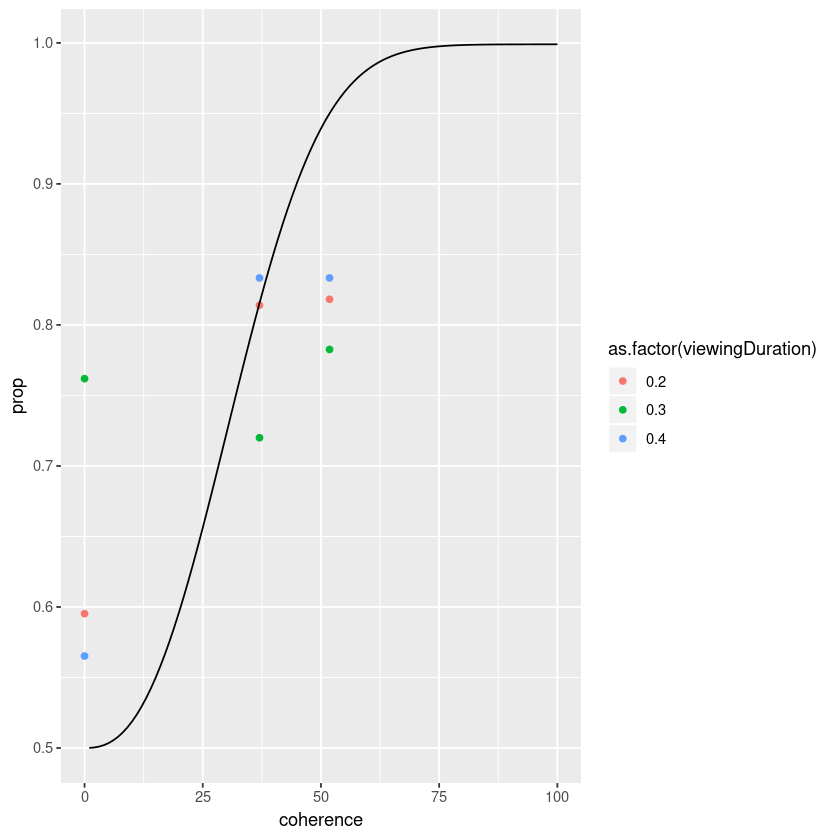

In [9]:
ggplot(data[pilotID==subj & taskID==2 & presenceCP=='no',
            .(prop=sum(correct==TRUE)/.N),by=.(coherence, viewingDuration)], aes(x=coherence, y=prop)) +
        geom_point(aes(col=as.factor(viewingDuration))) + 
        geom_line(aes(x=x, y=y), data=questCurve)

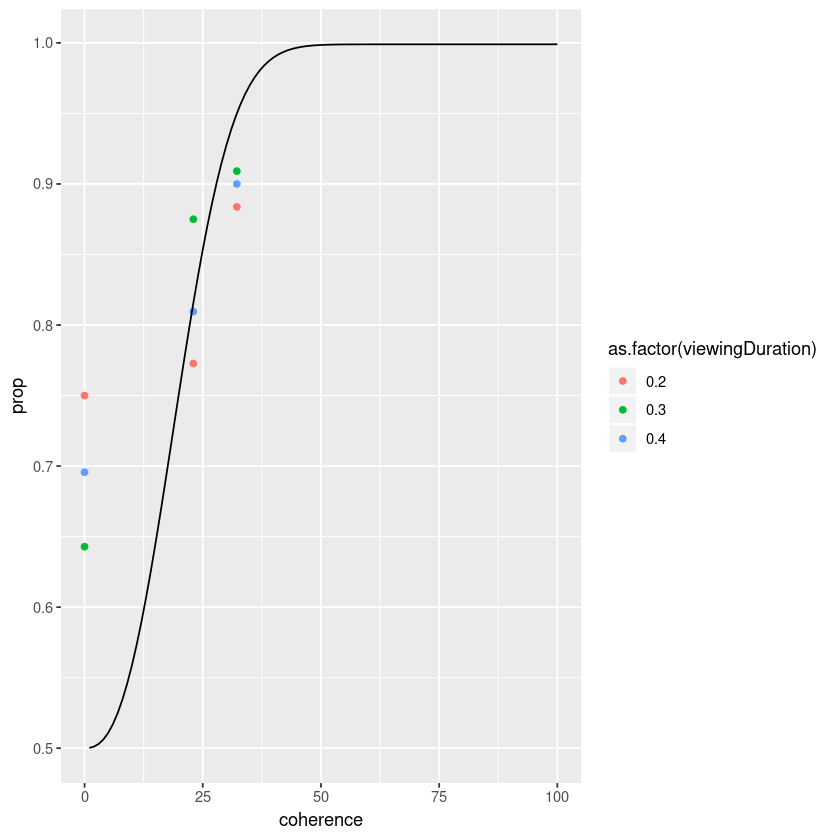

In [10]:
subj <- '14'
x <- seq(100)
psychometric <- psi_corr(weibull, QuestParams[[subj]])
y <- psychometric(x)

questCurve <- data.table(x=x, y=y)
ggplot(data[pilotID==subj & taskID==2 & presenceCP=='no',
            .(prop=sum(correct==TRUE)/.N),by=.(coherence, viewingDuration)], aes(x=coherence, y=prop)) +
        geom_point(aes(col=as.factor(viewingDuration))) + 
        geom_line(aes(x=x, y=y), data=questCurve)

## Simplest effects of CP on percent correct

**Question:** Does the physical presence of a CP affect state inference?  
**Hypotheses:** At fixed viewing duration the (physical) presence of a CP will decrease accuracy.  
**Method:** Hypothesis testing, i.e. is the difference in percent correct between the `CP` and `nonCP` conditions significantly different from 0?

Let's build a contingency table and perform [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test#Example).

In [11]:
subj <- '13'
task <- '2'
vd <- .4
maxCoh <- as.numeric(data[pilotID==subj & taskID==task, max(coherence)])
cat('max coh for subject', subj, 'on task', task, 'is', maxCoh, '\n')
contingency <- as.matrix(data[viewingDuration==vd & pilotID==subj & taskID==task & coherence>0 & coherence < maxCoh, 
                              .(Corrrect=sum(correct),Incorrect=sum(!correct)), by=presenceCP], rownames=TRUE)
t(contingency)
fisher.test(t(contingency)) # two-sided test; see ?fisher.test for help

max coh for subject 13 on task 2 is 51.81503 


,yes,no
Corrrect,24,15
Incorrect,2,3



	Fisher's Exact Test for Count Data

data:  t(contingency)
p-value = 0.3859
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.2398253 31.2533056
sample estimates:
odds ratio 
  2.351029 


In [12]:
subj <- '14'
maxCoh <- as.numeric(data[pilotID==subj & taskID==task, max(coherence)])
cat('max coh for subject', subj, 'on task', task, 'is', maxCoh, '\n')
contingency <- as.matrix(data[viewingDuration==vd & pilotID==subj & taskID==task & coherence>0 & coherence < maxCoh, 
                              .(Corrrect=sum(correct),Incorrect=sum(!correct)), by=presenceCP], rownames=TRUE)
t(contingency)
fisher.test(t(contingency)) # two-sided test; see ?fisher.test for help

max coh for subject 14 on task 2 is 32.20934 


,yes,no
Corrrect,17,17
Incorrect,6,4



	Fisher's Exact Test for Count Data

data:  t(contingency)
p-value = 0.724
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.1172459 3.4452526
sample estimates:
odds ratio 
 0.6728156 


We conclude that the test is not significant, i.e., we do **not** reject the null hypothesis that percent correct is the same with and without change points.

## Logistic regression

### Single predictor

#### Signed coherence
<a id="cohpred"></a>

We start super simple with the equation:
$$\log\frac{p_i}{1-p_i}=\beta_0+\beta_1x^\text{sc}_i$$
where $p_i$ is the proportion of right choices at stimulus level $i$ and $x^\text{sc}$ is the signed coherence value.
The current data (Pilot 11) has 11 stimulus levels, which correspond to the 11 signed coherence values: 

In [ ]:
subj <- '13'
task <- '2'

In [ ]:
unique(data[pilotID==subj & taskID==task & order(signedCohLast),.(signedCohLast)][,signedCohLast])

In [ ]:
fit_logistic_single_pred(data[pilotID==subj & taskID==task], choice, "right", signedCohLast)

In [ ]:
subj <- '14'
unique(data[pilotID==subj & taskID==task & order(signedCohLast),.(signedCohLast)][,signedCohLast])

In [ ]:
fit_logistic_single_pred(data[pilotID==subj & taskID==task], choice, "right", signedCohLast)

### Two predictors


## With `glm` function

In [ ]:
# psychometric[,numChooseLeft := N - numChooseRight]
# str(psychometric)

In [ ]:
# # let's first follow this example:
# # http://www.dlinares.org/psychopract.html#fitting-using-generalized-linear-models
# model <- glm( cbind(numChooseRight, numChooseLeft) ~ signedCoherence, 
#              data= psychometric, 
#              family = binomial(probit))

# xseq <- seq(-60, 60, 1)
# yseq <- predict(model, data.frame(signedCoherence = xseq), type = 'response')
# curve <- data.frame(xseq, yseq)

# p <- ggplot() +
#   geom_point(data = psychometric[,.(signedCoherence, chooseRight=numChooseRight / N)], 
#              aes(x = signedCoherence, y = chooseRight)) +
#   geom_line(data = curve,aes(x = xseq, y = yseq))
# p

The problem here is that I have a single regressor, namely, `signedCoherence`. This is not what I want.

In [ ]:
# Try instead this example
#https://www.statmethods.net/advstats/glm.html
# with good interpretation here:
# https://stats.idre.ucla.edu/r/dae/logit-regression/

In [ ]:
fit2 <- glm(choice ~ signedCohLast * exactVD + presenceCP, data = data, family=binomial())

In [ ]:
summary(fit2)

In [ ]:
anova(fit2)

In [ ]:
confint(fit2) # 95% CI for the coefficients, using profiled log-likelihood
confint.default(fit2)  # CIs using standard errors

In [ ]:
# odds ratios and 95% CI
exp(cbind(OddsRatio = coef(fit2), confint(fit2)))

In [ ]:
library("aod")
wald.test(b = coef(fit2), Sigma = vcov(fit2), Terms = 4)

In [ ]:
# better to use this
# https://stats.idre.ucla.edu/r/dae/logit-regression/
predict(fit2, type="response") # predicted values
residuals(fit2, type="deviance") # residuals

In [ ]:
cdplot(choice~signedCoherence, data=tmp_glm) 

In [ ]:
cdplot(choice~viewingDuration, data=tmp_glm) 

In [ ]:
# now try this
#https://datascienceplus.com/perform-logistic-regression-in-r/